In [59]:
import os
import pandas as pd

path_dataframes = os.path.join("..", "dataset", "dataframes")
file_path = os.path.join(path_dataframes, "train_data_labeled.pkl")
df_train_task3_labeled= pd.read_pickle(file_path)

df_train_task3_labeled


,TIME,P1,P2,P3,P4,P5,P6,P7,Case,Spacecraft,...,SV3,SV4,BP1,BP2,BP3,BP4,BP5,BP6,BP7,BV1
0,0.000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,1,1,...,100,100,No,No,No,No,No,No,No,No
1,0.001,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,1,1,...,100,100,No,No,No,No,No,No,No,No
2,0.002,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,1,1,...,100,100,No,No,No,No,No,No,No,No
3,0.003,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,1,1,...,100,100,No,No,No,No,No,No,No,No
4,0.004,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,1,1,...,100,100,No,No,No,No,No,No,No,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
212572,1.196,1.948734,1.912482,1.904362,1.835654,1.924899,1.857220,1.920020,177,3,...,100,100,No,No,No,No,No,No,No,Yes
212573,1.197,1.948823,1.899824,1.884360,1.825497,1.927513,1.846068,1.919081,177,3,...,100,100,No,No,No,No,No,No,No,Yes
212574,1.198,1.957784,1.911383,1.893740,1.859805,1.940953,1.861668,1.950562,177,3,...,100,100,No,No,No,No,No,No,No,Yes
212575,1.199,1.970451,1.950009,1.945417,1.913911,1.953648,1.835381,1.983321,177,3,...,100,100,No,No,No,No,No,No,No,Yes


In [60]:
# Filtrare solo le righe in cui Condition è 'Anomaly'
df_train_task3_anomaly = df_train_task3_labeled[df_train_task3_labeled['Condition'] == 'Anomaly'].copy()
print(df_train_task3_anomaly.shape)

# Dizionario per mappare i sensori sulle classi numeriche
column_to_number = {'BP1': 1, 'BP2': 2, 'BP3': 3, 'BP4': 4, 'BP5': 5, 'BP6': 6, 'BP7': 7, 'BV1': 8}

# Creazione della colonna target
df_train_task3_anomaly['anomaly_location'] = 0

# Popolamento della colonna target
for index, row in df_train_task3_anomaly.iterrows():
    for col in column_to_number.keys():
        if row[col] == 'Yes':  # Se il sensore rileva un'anomalia
            df_train_task3_anomaly.at[index, 'anomaly_location'] = column_to_number[col]
            break  # Assegna la prima anomalia trovata e interrompi il ciclo

# Suddivisione del dataset in base agli intervalli temporali (0-400 ms, 400-800 ms, 800-1200 ms)
df_phase1 = df_train_task3_anomaly[(df_train_task3_anomaly["TIME"] >= 0) & (df_train_task3_anomaly["TIME"] < 0.4)]
df_phase2 = df_train_task3_anomaly[(df_train_task3_anomaly["TIME"] >= 0.4) & (df_train_task3_anomaly["TIME"] < 0.8)]
df_phase3 = df_train_task3_anomaly[(df_train_task3_anomaly["TIME"] >= 0.8) & (df_train_task3_anomaly["TIME"] <= 1.2)]

# Concatenare le tre fasi per triplicare il dataset
df_augmented_time = pd.concat([df_phase1, df_phase2, df_phase3], axis=0).reset_index(drop=True)
print(df_augmented_time)

(28824, 23)
        TIME        P1        P2        P3        P4        P5        P6  \
0      0.000  2.000000  2.000000  2.000000  2.000000  2.000000  2.000000   
1      0.001  2.000000  2.000000  2.000000  2.000000  2.000000  2.000000   
2      0.002  2.000000  2.000000  2.000000  2.000000  2.000000  2.000000   
3      0.003  2.000000  2.000000  2.000000  2.000000  2.000000  2.000000   
4      0.004  2.000000  2.000000  2.000000  2.000000  2.000000  2.000000   
...      ...       ...       ...       ...       ...       ...       ...   
28819  1.196  1.948734  1.912482  1.904362  1.835654  1.924899  1.857220   
28820  1.197  1.948823  1.899824  1.884360  1.825497  1.927513  1.846068   
28821  1.198  1.957784  1.911383  1.893740  1.859805  1.940953  1.861668   
28822  1.199  1.970451  1.950009  1.945417  1.913911  1.953648  1.835381   
28823  1.200  1.988895  1.997232  2.003571  1.989339  1.981822  1.888756   

             P7  Case  Spacecraft  ...  SV4  BP1  BP2  BP3  BP4 BP5 BP6 BP7

## Task 3

Utilizziamo il dataset di feature annotato

In [61]:
import os
import pandas as pd

path_dataframes = os.path.join("..", "dataset", "dataframes")
file_path = os.path.join(path_dataframes, "train_data_aggregated.pkl")

df_train_task3_aggregated = pd.read_pickle(file_path)

df_train_task3_aggregated

,Spacecraft,Condition,SV1,SV2,SV3,SV4,BP1,BP2,BP3,BP4,...,P7_time_variance,P7_time_line_integral,P7_time_min,P7_time_max,P7_freq_peak_value,P7_freq_peak_freq,P7_freq_sum_power_spectrum,P7_freq_std_power_spectrum,P7_freq_rms_freq,Case
0,1,Normal,100,100,100,100,No,No,No,No,...,0.329054,2366.012724,-0.003006,5.017115,47260.680479,64.945878,237314.084554,2632.685347,19.887772,1
1,1,Normal,100,100,100,100,No,No,No,No,...,0.335404,2366.376508,-0.003786,4.999330,47662.864823,64.945878,241893.822061,2688.225229,20.078754,2
2,1,Normal,100,100,100,100,No,No,No,No,...,0.353392,2368.725329,-0.007141,5.000936,46019.998152,64.945878,254866.442384,2743.060363,20.610129,3
3,1,Normal,100,100,100,100,No,No,No,No,...,0.321221,2365.701657,-0.002395,5.008294,46367.986582,64.945878,231664.969366,2565.994380,19.649638,4
4,1,Normal,100,100,100,100,No,No,No,No,...,0.324006,2366.740718,-0.002607,4.998044,46805.662115,64.945878,233673.009183,2592.227655,19.734615,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
172,3,Anomaly,100,100,100,100,No,No,No,Yes,...,0.307552,2361.961235,0.000442,4.918386,35087.812714,59.950042,221806.924274,2048.184913,19.227018,173
173,3,Anomaly,100,100,100,100,No,No,No,No,...,0.387815,2363.165121,-0.015324,5.228732,28697.613718,62.447960,279692.093116,2114.129783,21.590588,174
174,3,Anomaly,100,100,100,100,No,No,No,No,...,0.346742,2364.069197,0.001778,5.513235,34926.326106,59.950042,250070.258482,1959.034040,20.415283,175
175,3,Anomaly,100,100,100,100,No,No,No,No,...,0.347191,2371.499487,0.266158,4.747359,50273.765483,59.950042,250394.249590,2615.638149,20.428503,176


Filtriamo il dataframe per casi di Condition Anomaly (errori per Bubble Contamination)

Modifica 1

In [62]:
# Filtrare solo le righe in cui Condition è 'Anomaly'
df_train_task3_aggregated = df_train_task3_aggregated[df_train_task3_aggregated['Condition'] == 'Anomaly'].copy()

# Dizionario per mappare i sensori sulle classi numeriche
column_to_number = {'BP1': 1, 'BP2': 2, 'BP3': 3, 'BP4': 4, 'BP5': 5, 'BP6': 6, 'BP7': 7, 'BV1': 8}

# Creazione della colonna target 
df_train_task3_aggregated['anomaly_location'] = df_train_task3_aggregated[column_to_number.keys()].apply(
    lambda row: [column_to_number[col] for col in column_to_number.keys() if row[col] == 'Yes'],
    axis=1
)

# Salvataggio del dataset filtrato con target aggiornato
df_train_task3_aggregated.to_csv(os.path.join(path_dataframes, "dataset_train_task3_with_target.csv"), index=False)

# Mostrare alcune righe per conferma
df_train_task3_aggregated[['Condition', 'BP1', 'BP2', 'BP3', 'BP4', 'BP5', 'BP6', 'BP7', 'BV1', 'anomaly_location']]

,Condition,BP1,BP2,BP3,BP4,BP5,BP6,BP7,BV1,anomaly_location
153,Anomaly,Yes,No,No,No,No,No,No,No,[1]
154,Anomaly,No,Yes,No,No,No,No,No,No,[2]
155,Anomaly,No,No,Yes,No,No,No,No,No,[3]
156,Anomaly,No,No,No,Yes,No,No,No,No,[4]
157,Anomaly,No,No,No,No,Yes,No,No,No,[5]
158,Anomaly,No,No,No,No,No,Yes,No,No,[6]
159,Anomaly,No,No,No,No,No,No,Yes,No,[7]
160,Anomaly,No,No,No,No,No,No,No,Yes,[8]
161,Anomaly,Yes,No,No,No,No,No,No,No,[1]
162,Anomaly,No,Yes,No,No,No,No,No,No,[2]


Filtro le colonne che non servono, poi faccio features selection con ANOVA e Chi2

In [63]:
df_train_task3_aggregated['anomaly_location'] = df_train_task3_aggregated['anomaly_location'].apply(lambda x: x[0] if isinstance(x, list) and len(x) > 0 else np.nan)


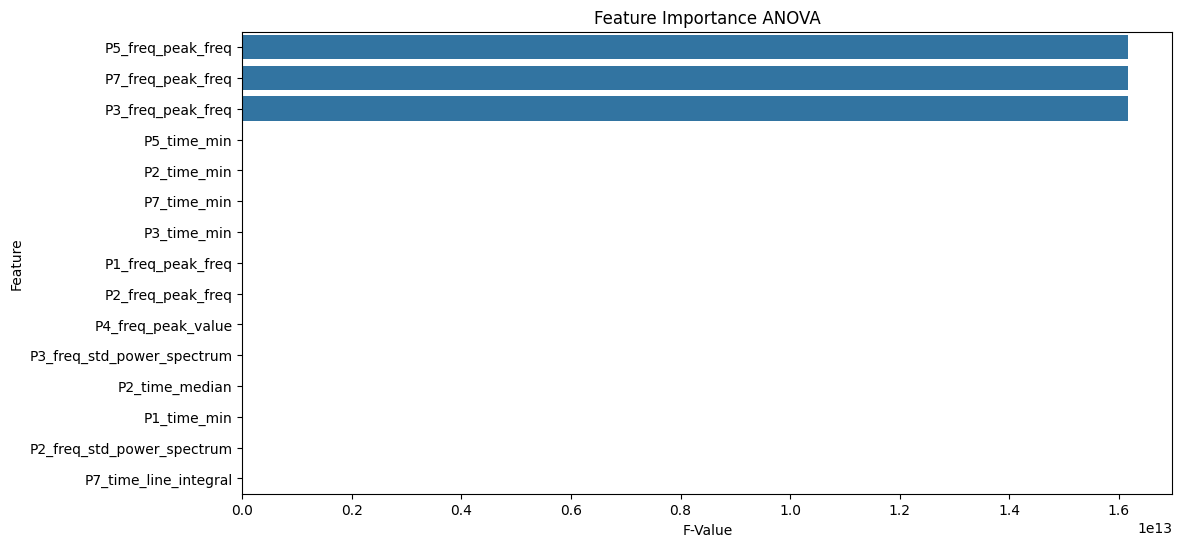

In [64]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import f_classif

# Separazione delle feature dal target
X = df_train_task3_aggregated.drop(columns=['Spacecraft','BP1','BP2','BP3','BP4','BP5','BP6', 'BP7', 'BV1','SV1','SV2','SV3','SV4','anomaly_location', 'Condition'])  # Escludi il target e la colonna Condition
y = df_train_task3_aggregated['anomaly_location']

# Calcolo del valore F di ANOVA
f_values, p_values = f_classif(X, y)

# Creazione di un DataFrame con i risultati
anova_results = pd.DataFrame({'Feature': X.columns, 'F-Value': f_values, 'P-Value': p_values})
anova_results = anova_results.sort_values(by='F-Value', ascending=False)

# Visualizzazione delle feature più importanti
plt.figure(figsize=(12, 6))
sns.barplot(x='F-Value', y='Feature', data=anova_results[:15])
plt.title('Feature Importance ANOVA')
plt.show()


Features Selection Chi2

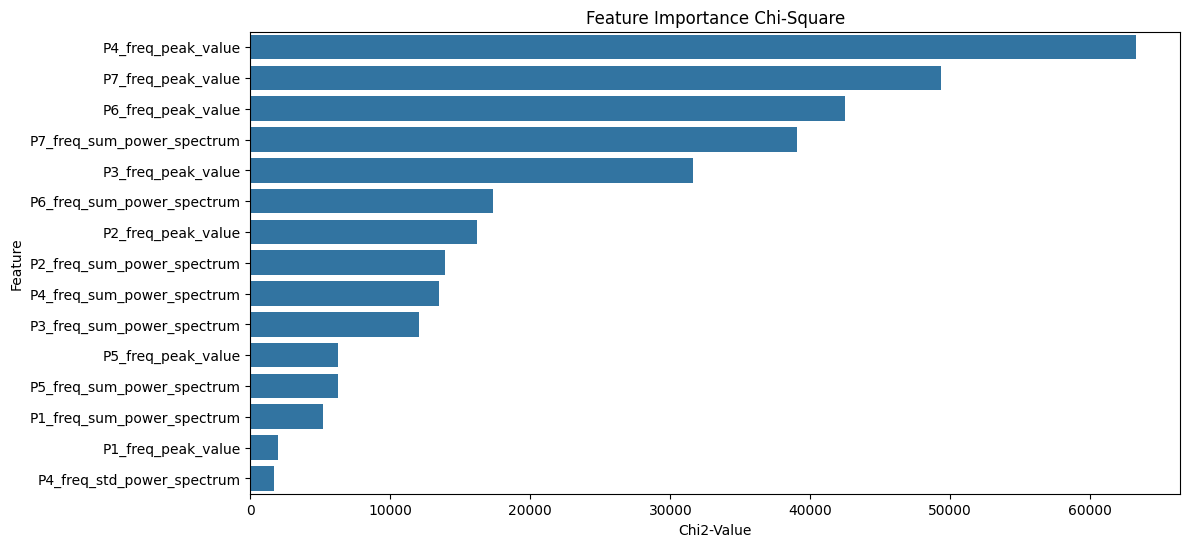

In [65]:
from sklearn.feature_selection import chi2
import numpy as np

# Normalizzazione delle feature per Chi2 (richiede solo valori positivi)
X_chi2 = X - np.min(X) + 1  # Shift per evitare valori negativi
y_chi2 = y

# Calcolo del valore Chi2
chi2_values, chi2_p_values = chi2(X_chi2, y_chi2)

# Creazione di un DataFrame con i risultati
chi2_results = pd.DataFrame({'Feature': X.columns, 'Chi2-Value': chi2_values, 'P-Value': chi2_p_values})
chi2_results = chi2_results.sort_values(by='Chi2-Value', ascending=False)

# Visualizzazione delle feature più importanti
plt.figure(figsize=(12, 6))
sns.barplot(x='Chi2-Value', y='Feature', data=chi2_results[:15])
plt.title('Feature Importance Chi-Square')
plt.show()


Unisco le feature più importanti in output dai due metodi

In [66]:
# Unire le feature più importanti di ANOVA e Chi2
top_features_anova = anova_results[:15]['Feature'].tolist()
top_features_chi2 = chi2_results[:15]['Feature'].tolist()

# Creare una lista unica delle feature selezionate
selected_features = list(set(top_features_anova + top_features_chi2))

# Numero di feature utilizzate per l'addestramento
num_features = len(selected_features)
print(f"Numero di feature utilizzate per il training: {num_features}")

# Visualizzare le feature selezionate
print("Feature selezionate:", selected_features)

# Creare il dataset con le feature selezionate
df_selected = df_train_task3_aggregated[selected_features + ['anomaly_location']]
df_selected

Numero di feature utilizzate per il training: 29
Feature selezionate: ['P3_time_min', 'P5_freq_sum_power_spectrum', 'P3_freq_peak_freq', 'P7_time_min', 'P2_freq_peak_value', 'P5_time_min', 'P1_freq_peak_value', 'P4_freq_peak_value', 'P2_time_median', 'P3_freq_peak_value', 'P7_freq_peak_freq', 'P5_freq_peak_value', 'P4_freq_std_power_spectrum', 'P3_freq_std_power_spectrum', 'P6_freq_sum_power_spectrum', 'P5_freq_peak_freq', 'P2_freq_std_power_spectrum', 'P3_freq_sum_power_spectrum', 'P1_time_min', 'P7_freq_peak_value', 'P2_freq_sum_power_spectrum', 'P6_freq_peak_value', 'P1_freq_peak_freq', 'P7_time_line_integral', 'P1_freq_sum_power_spectrum', 'P4_freq_sum_power_spectrum', 'P2_time_min', 'P7_freq_sum_power_spectrum', 'P2_freq_peak_freq']


,P3_time_min,P5_freq_sum_power_spectrum,P3_freq_peak_freq,P7_time_min,P2_freq_peak_value,P5_time_min,P1_freq_peak_value,P4_freq_peak_value,P2_time_median,P3_freq_peak_value,...,P2_freq_sum_power_spectrum,P6_freq_peak_value,P1_freq_peak_freq,P7_time_line_integral,P1_freq_sum_power_spectrum,P4_freq_sum_power_spectrum,P2_time_min,P7_freq_sum_power_spectrum,P2_freq_peak_freq,anomaly_location
153,-0.003067,151879.969351,64.945878,0.000599,23956.453644,0.000563,10802.636968,31959.671511,1.930621,28611.180559,...,137404.314915,36218.345696,64.945878,2361.286896,68283.002587,198781.726242,0.274147,226086.946314,64.945878,1
154,0.215499,147313.770081,62.447960,-0.003637,29519.582443,0.020600,10735.216150,34667.506912,1.919967,33080.232012,...,147631.914817,34191.252648,62.447960,2366.205104,65146.357969,238159.901617,0.562916,217794.811254,62.447960,2
155,0.488051,138937.165659,59.950042,-0.004556,22405.240961,0.019675,7917.770581,31317.015317,1.923975,32309.205471,...,140512.179038,27103.217344,59.950042,2366.238784,60905.470439,260115.579000,0.103320,206899.259856,59.950042,3
156,0.004618,135298.220659,59.950042,0.011591,27973.038166,-0.001572,9475.374287,47903.191043,1.918731,32068.021287,...,144303.979111,31437.121069,59.950042,2361.818259,61499.968684,242451.446171,0.053372,216228.884135,59.950042,4
157,0.001759,158908.528301,62.447960,-0.005569,20748.702617,0.482296,9489.428532,24055.889699,1.946931,22498.015545,...,128013.954373,39322.217865,62.447960,2358.758370,61449.399064,197384.051931,0.021869,249360.397790,62.447960,5
158,-0.002811,151670.183732,59.950042,-0.001953,22468.254175,0.287499,10420.485801,25033.935950,1.943923,23886.984831,...,123137.615311,63180.492534,59.950042,2363.743831,56908.957467,192121.549995,0.024311,267736.784732,59.950042,6
159,-0.002429,150656.715064,59.950042,0.349276,21111.691154,0.202666,9708.256727,22356.103914,1.949996,21373.036047,...,123975.728475,42550.576548,59.950042,2371.162469,55911.695165,192557.994856,0.016551,278646.868744,59.950042,7
160,-0.003041,153795.654644,64.945878,-0.001480,24425.133285,0.000563,10766.257716,32274.528351,1.927557,28627.565258,...,140164.983855,36495.622531,64.945878,2360.344570,64957.929853,200215.512432,0.246233,220274.187255,64.945878,8
161,-0.002452,145786.995033,64.945878,-0.003207,24088.431939,0.000563,11074.908154,32105.578256,1.926315,30091.159628,...,140448.081123,36402.106141,64.945878,2359.249664,65785.021148,249457.937097,0.268553,225077.443121,64.945878,1
162,0.215499,141416.369424,62.447960,-0.003646,30187.095143,0.017047,10907.343218,34536.942712,1.916744,34811.747903,...,153392.598010,34194.215731,62.447960,2365.532333,63462.454676,257493.895496,0.561062,210440.726760,62.447960,2


PROBLEMA: pochi casi di Train per le Bubble Contmination, proviamo ad aumentare i campioni

Controllo la distribuzione delle classi prima

C:\Users\mauro\AppData\Local\Temp\ipykernel_17432\3434480410.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df_selected['anomaly_location'], palette="viridis")


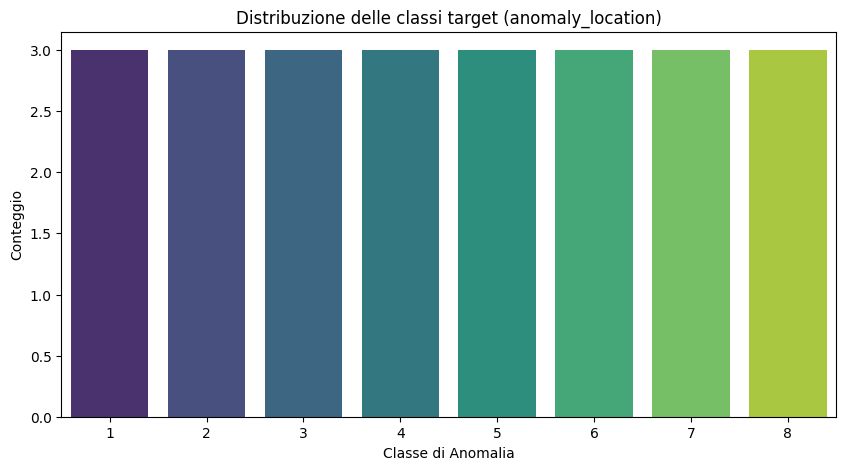

In [67]:
# Controllo distribuzione delle classi target
plt.figure(figsize=(10, 5))
sns.countplot(x=df_selected['anomaly_location'], palette="viridis")
plt.title("Distribuzione delle classi target (anomaly_location)")
plt.xlabel("Classe di Anomalia")
plt.ylabel("Conteggio")
plt.show()

Modifica 2: il dataset veniva triplicato per aumentare i dati di training, sostituito df_augmented con df_balanced

C:\Users\mauro\AppData\Local\Temp\ipykernel_17432\3692270016.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_balanced = df_selected.groupby('anomaly_location', group_keys=False).apply(
C:\Users\mauro\AppData\Local\Temp\ipykernel_17432\3692270016.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df_balanced['anomaly_location'], palette="viridis")


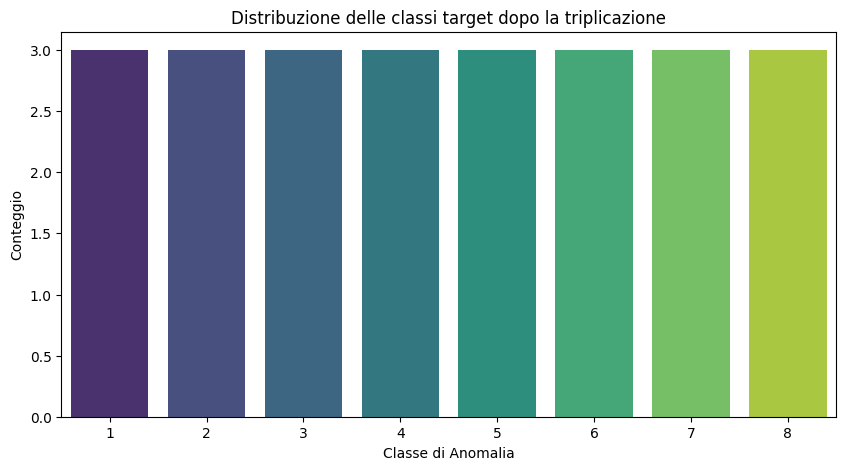

In [68]:
import pandas as pd
from sklearn.utils import resample

# Sovra-campionamento per ottenere un dataset bilanciato
df_balanced = df_selected.groupby('anomaly_location', group_keys=False).apply(
    lambda x: resample(x, replace=True, n_samples=df_selected['anomaly_location'].value_counts().max(), random_state=42)
).reset_index(drop=True)

# Salvataggio del dataset aumentato
df_balanced.to_csv(os.path.join(path_dataframes, "dataset_train_task3_triplicated.csv"), index=False)

# Controllo distribuzione dopo l'aumento
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 5))
sns.countplot(x=df_balanced['anomaly_location'], palette="viridis")
plt.title("Distribuzione delle classi target dopo la triplicazione")
plt.xlabel("Classe di Anomalia")
plt.ylabel("Conteggio")
plt.show()


Modifica 2: il dataset veniva triplicato per aumentare i dati di training, sostituito df_augmented con df_balanced

In [69]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Separazione feature e target
X = df_balanced.drop(columns=['anomaly_location'])
y = df_balanced['anomaly_location']

# Suddivisione in training e test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Normalizzazione delle feature
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [70]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Creazione e addestramento del modello
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train_scaled, y_train)

# Predizione sul test set
y_pred = clf.predict(X_test_scaled)

# Report delle prestazioni
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Confusion Matrix:
 [[1 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0]
 [0 0 0 1 0 0 0 0]
 [0 0 0 0 1 0 0 0]
 [0 0 0 0 0 1 0 0]
 [0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0 1]]

Classification Report:
               precision    recall  f1-score   support

           1       1.00      1.00      1.00         1
           2       1.00      1.00      1.00         1
           3       1.00      1.00      1.00         1
           4       1.00      1.00      1.00         1
           5       1.00      1.00      1.00         1
           6       1.00      1.00      1.00         1
           7       1.00      1.00      1.00         1
           8       1.00      1.00      1.00         1

    accuracy                           1.00         8
   macro avg       1.00      1.00      1.00         8
weighted avg       1.00      1.00      1.00         8



Salvo il modello di Random Forest

In [71]:
import pickle

# Salvare il modello con il nome anomaly_locations.pkl
with open("anomaly_locations.pkl", "wb") as f:
    pickle.dump(clf, f)


Carico il modello

In [72]:
# Caricare il dataset di test con le predizioni
df_test = pd.read_csv("../dataset/dataframes/test_data_output_task2.csv")

# Estrarre gli indici dei Case con Predicted_Condition == "Anomaly"
anomaly_cases = df_test[df_test["Predicted_Condition"] == "Anomaly"]["Case"].tolist()
print("Casi predetti come Anomaly in Output dal Task2:", anomaly_cases)

Casi predetti come Anomaly in Output dal Task2: [178, 186, 196, 197, 204, 209, 219, 221]


Carico il dataset di test originale aggregato, lasciando solamente i casi corrispondenti ad Anomaly

In [73]:
# Caricare il dataset delle feature originali
df_test_aggregated = pd.read_csv("../dataset/dataframes/test_data_aggregated.csv")

# Filtrare solo le righe che corrispondono agli 8 Case previsti come Anomaly
df_test_anomaly_features = df_test_aggregated[df_test_aggregated["Case"].isin(anomaly_cases)].copy()

# Verificare che il numero di righe filtrate sia esattamente 8
print(f"Numero di righe filtrate per Anomaly: {df_test_anomaly_features.shape[0]}")

Numero di righe filtrate per Anomaly: 8


Filtriamo il Dataset con i casi di Anomaly di test nelle feature scelte in classificazione (Locations features)

In [74]:

# Filtrare il dataset di test utilizzando le stesse feature
X_test_filtered = df_test_anomaly_features[selected_features]
print(f"Numero di campioni filtrati per il test: {X_test_filtered.shape[0]}")
print(X_test_filtered.head())

Numero di campioni filtrati per il test: 8
    P3_time_min  P5_freq_sum_power_spectrum  P3_freq_peak_freq  P7_time_min  \
0      0.215499               147313.770081          62.447960    -0.003637   
8     -0.002784               150357.607576          59.950042    -0.001868   
18     0.004618               135298.220659          59.950042     0.011591   
19    -0.002437               150774.739236          59.950042     0.349584   
26     0.570368               138449.071673          59.950042    -0.004429   

    P2_freq_peak_value  P5_time_min  P1_freq_peak_value  P4_freq_peak_value  \
0         29519.582443     0.020600        10735.216150        34667.506912   
8         22286.743522     0.287499        10324.925235        24829.072833   
18        27973.038166    -0.001572         9475.374287        47903.191043   
19        21155.259104     0.202531         9731.493098        22396.393747   
26        24544.577458     0.019675         8590.029510        34211.786379   

    P2_

Carico il modello ed effettuo la predizione delle location su questi dati

Modifica 3:
Nel training si normalizzava i dati con StandardScaler, ma nel test no.

In [75]:
# Caricare il modello salvato
with open("anomaly_locations.pkl", "rb") as f:
    clf_loaded = pickle.load(f)

# Applicare la stessa normalizzazione usata nel training
X_test_scaled = scaler.transform(X_test_filtered)

# Effettuare la predizione sul dataset normalizzato
y_pred_anomaly = clf_loaded.predict(X_test_scaled)

# Creare un DataFrame con le predizioni
df_predictions = pd.DataFrame({
    "Case": df_test_anomaly_features["Case"],
    "Predicted_Anomaly_Location": y_pred_anomaly
})

print(df_predictions)


    Case  Predicted_Anomaly_Location
0    178                           2
8    186                           6
18   196                           4
19   197                           7
26   204                           3
31   209                           7
41   219                           5
43   221                           2


In [76]:
# Salviamo il df delle predizioni in formato CSV e Pickle
df_predictions.to_csv("../dataset/dataframes/test_data_output_task3.csv", index=False)
df_predictions.to_pickle("../dataset/dataframes/test_data_output_task3.pkl")
